In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
sns.set(style='whitegrid')

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [3]:
from sklearn.preprocessing import LabelEncoder 
labelEncoder= LabelEncoder()
train['Gender'] = labelEncoder.fit_transform(train['Gender'])
train['Vehicle_Age'] = labelEncoder.fit_transform(train['Vehicle_Age'])
train['Vehicle_Damage'] = labelEncoder.fit_transform(train['Vehicle_Damage'])

In [4]:
X=train.drop(['Response','id'],axis=1) 
y=train['Response'] 

Original dataset shape Counter({0: 334399, 1: 46710})
Resampled dataset shape Counter({1: 334399, 0: 334399})


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Response', ylabel='count'>

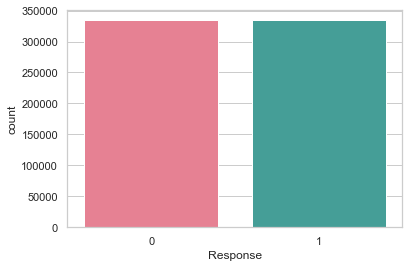

In [5]:
from imblearn.over_sampling import RandomOverSampler

randomsample=  RandomOverSampler()
X_new,y_new=randomsample.fit_resample(X,y)

from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))
sns.countplot(y_new,palette='husl')

In [6]:
from sklearn.model_selection import train_test_split

#Training and Test Data for Model Selection
X_train, X_test, y_train, y_test= train_test_split(X_new, y_new, test_size=0.25, random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

#Data Pre-Processing
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

(501598, 10) (167200, 10) (501598,) (167200,)


In [7]:
import xgboost as xgb
from sklearn.metrics import accuracy_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [8]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [9]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [10]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                 
0.7976016746411483                                     
  1%|          | 1/100 [01:58<3:16:00, 118.79s/trial, best loss: -0.7976016746411483]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                               
0.7969617224880383                                                                   
  2%|▏         | 2/100 [03:00<2:45:51, 101.55s/trial, best loss: -0.7976016746411483]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                               
0.7965909090909091                                                                   
  3%|▎         | 3/100 [04:33<2:40:06, 99.04s/trial, best loss: -0.7976016746411483] 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                              
0.7976196172248804                                                                  
  4%|▍         | 4/100 [07:00<3:01:35, 113.49s/trial, best loss: -0.7976196172248804]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                               
0.7970514354066985                                                                   
  5%|▌         | 5/100 [08:50<2:58:09, 112.52s/trial, best loss: -0.7976196172248804]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                               
0.7972428229665072                                                                   
  6%|▌         | 6/100 [10:14<2:42:56, 104.01s/trial, best loss: -0.7976196172248804]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                               
0.7972727272727272                                                                   
  7%|▋         | 7/100 [12:04<2:43:47, 105.67s/trial, best loss: -0.7976196172248804]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                               
0.7976614832535885                                                                   
  8%|▊         | 8/100 [13:39<2:36:58, 102.37s/trial, best loss: -0.7976614832535885]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                               
0.7975119617224881                                                                   
  9%|▉         | 9/100 [15:41<2:44:22, 108.38s/trial, best loss: -0.7976614832535885]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                               
0.7968241626794258                                                                   
 10%|█         | 10/100 [17:09<2:33:28, 102.31s/trial, best loss: -0.7976614832535885]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.797183014354067                                                                     
 11%|█         | 11/100 [18:38<2:25:46, 98.28s/trial, best loss: -0.7976614832535885] 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                               
0.7976854066985646                                                                   
 12%|█▏        | 12/100 [21:03<2:44:50, 112.39s/trial, best loss: -0.7976854066985646]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7968839712918661                                                                    
 13%|█▎        | 13/100 [23:09<2:48:38, 116.30s/trial, best loss: -0.7976854066985646]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7973684210526316                                                                    
 14%|█▍        | 14/100 [25:06<2:47:01, 116.53s/trial, best loss: -0.7976854066985646]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7978528708133972                                                                    
 15%|█▌        | 15/100 [27:42<3:01:46, 128.32s/trial, best loss: -0.7978528708133972]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7971411483253589                                                                    
 16%|█▌        | 16/100 [30:11<3:08:20, 134.54s/trial, best loss: -0.7978528708133972]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7973444976076555                                                                    
 17%|█▋        | 17/100 [32:18<3:02:58, 132.27s/trial, best loss: -0.7978528708133972]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7972248803827752                                                                    
 18%|█▊        | 18/100 [34:12<2:53:19, 126.82s/trial, best loss: -0.7978528708133972]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7971112440191388                                                                    
 19%|█▉        | 19/100 [36:00<2:43:41, 121.26s/trial, best loss: -0.7978528708133972]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.796555023923445                                                                     
 20%|██        | 20/100 [38:06<2:43:22, 122.53s/trial, best loss: -0.7978528708133972]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7985346889952153                                                                    
 21%|██        | 21/100 [40:56<3:00:14, 136.90s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7984031100478469                                                                    
 22%|██▏       | 22/100 [44:15<3:22:02, 155.41s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7984449760765551                                                                    
 23%|██▎       | 23/100 [47:14<3:28:37, 162.57s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7982954545454546                                                                    
 24%|██▍       | 24/100 [49:41<3:19:56, 157.85s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7979964114832536                                                                    
 25%|██▌       | 25/100 [52:59<3:32:18, 169.84s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7977212918660287                                                                    
 26%|██▌       | 26/100 [55:50<3:29:56, 170.22s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7979904306220096                                                                    
 27%|██▋       | 27/100 [58:32<3:24:12, 167.84s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7979784688995215                                                                      
 28%|██▊       | 28/100 [1:01:08<3:17:18, 164.42s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7979844497607655                                                                      
 29%|██▉       | 29/100 [1:04:04<3:18:25, 167.69s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7979545454545455                                                                      
 30%|███       | 30/100 [1:06:45<3:13:28, 165.84s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7979844497607655                                                                      
 31%|███       | 31/100 [1:09:25<3:08:32, 163.95s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7966746411483253                                                                      
 32%|███▏      | 32/100 [1:11:00<2:42:32, 143.42s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7970933014354067                                                                      
 33%|███▎      | 33/100 [1:13:21<2:39:10, 142.55s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7979007177033492                                                                      
 34%|███▍      | 34/100 [1:16:32<2:52:46, 157.07s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7978648325358851                                                                      
 35%|███▌      | 35/100 [1:19:16<2:52:27, 159.19s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.797799043062201                                                                       
 36%|███▌      | 36/100 [1:22:16<2:56:23, 165.37s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7978887559808613                                                                      
 37%|███▋      | 37/100 [1:25:08<2:55:56, 167.56s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7979126794258373                                                                      
 38%|███▊      | 38/100 [1:27:31<2:45:26, 160.10s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7979126794258373                                                                      
 39%|███▉      | 39/100 [1:30:04<2:40:38, 158.01s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7975897129186603                                                                      
 40%|████      | 40/100 [1:31:58<2:24:54, 144.90s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7977212918660287                                                                      
 41%|████      | 41/100 [1:34:15<2:20:08, 142.52s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7976854066985646                                                                      
 42%|████▏     | 42/100 [1:36:37<2:17:35, 142.34s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7969736842105263                                                                      
 43%|████▎     | 43/100 [1:38:30<2:06:43, 133.39s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7979306220095693                                                                      
 44%|████▍     | 44/100 [1:40:29<2:00:37, 129.24s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7976854066985646                                                                      
 45%|████▌     | 45/100 [1:42:14<1:51:41, 121.85s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7966267942583732                                                                      
 46%|████▌     | 46/100 [1:43:29<1:36:56, 107.72s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.797194976076555                                                                       
 47%|████▋     | 47/100 [1:44:41<1:25:51, 97.19s/trial, best loss: -0.7985346889952153] 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                 
0.7975897129186603                                                                     
 48%|████▊     | 48/100 [1:46:11<1:22:20, 95.01s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                 
0.7972607655502393                                                                     
 49%|████▉     | 49/100 [1:47:53<1:22:31, 97.10s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                 
0.7964354066985646                                                                     
 50%|█████     | 50/100 [1:48:53<1:11:34, 85.90s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                 
0.7977033492822967                                                                     
 51%|█████     | 51/100 [1:50:38<1:14:42, 91.47s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                 
0.797505980861244                                                                      
 52%|█████▏    | 52/100 [1:51:52<1:09:12, 86.50s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                 
0.7979425837320574                                                                     
 53%|█████▎    | 53/100 [2:23:45<8:16:53, 634.32s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7976196172248804                                                                      
 54%|█████▍    | 54/100 [2:25:35<6:05:40, 476.98s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7981997607655502                                                                      
 55%|█████▌    | 55/100 [2:27:58<4:42:40, 376.91s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7972667464114832                                                                      
 56%|█████▌    | 56/100 [2:30:13<3:43:02, 304.15s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7968181818181819                                                                      
 57%|█████▋    | 57/100 [2:32:19<2:59:38, 250.67s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7979784688995215                                                                      
 58%|█████▊    | 58/100 [2:34:50<2:34:36, 220.87s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.797811004784689                                                                       
 59%|█████▉    | 59/100 [2:37:27<2:17:55, 201.83s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.796555023923445                                                                       
 60%|██████    | 60/100 [2:39:15<1:55:44, 173.61s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.797799043062201                                                                       
 61%|██████    | 61/100 [2:41:35<1:46:18, 163.54s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7975299043062201                                                                      
 62%|██████▏   | 62/100 [2:43:54<1:38:53, 156.16s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7978648325358851                                                                      
 63%|██████▎   | 63/100 [2:46:15<1:33:24, 151.46s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7982416267942584                                                                      
 64%|██████▍   | 64/100 [2:48:59<1:33:09, 155.26s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7974641148325359                                                                      
 65%|██████▌   | 65/100 [2:51:49<1:33:12, 159.79s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7984748803827751                                                                      
 66%|██████▌   | 66/100 [2:54:22<1:29:28, 157.88s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7979844497607655                                                                      
 67%|██████▋   | 67/100 [2:56:44<1:24:09, 153.02s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7983492822966507                                                                      
 68%|██████▊   | 68/100 [2:59:22<1:22:21, 154.42s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7982296650717703                                                                      
 69%|██████▉   | 69/100 [3:02:00<1:20:17, 155.41s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7978588516746411                                                                      
 70%|███████   | 70/100 [3:04:40<1:18:23, 156.78s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7976674641148326                                                                      
 71%|███████   | 71/100 [3:07:00<1:13:27, 151.98s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7979425837320574                                                                      
 72%|███████▏  | 72/100 [3:09:42<1:12:20, 155.01s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7979844497607655                                                                      
 73%|███████▎  | 73/100 [3:12:22<1:10:25, 156.50s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7978827751196172                                                                      
 74%|███████▍  | 74/100 [3:14:49<1:06:28, 153.41s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7980921052631579                                                                      
 75%|███████▌  | 75/100 [3:17:31<1:05:04, 156.17s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7978169856459331                                                                      
 76%|███████▌  | 76/100 [3:20:15<1:03:24, 158.53s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                  
0.7976854066985646                                                                      
 77%|███████▋  | 77/100 [3:22:47<59:57, 156.43s/trial, best loss: -0.7985346889952153]  

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7979007177033492                                                                    
 78%|███████▊  | 78/100 [3:25:35<58:37, 159.91s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7978169856459331                                                                    
 79%|███████▉  | 79/100 [3:28:15<55:57, 159.90s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7976734449760765                                                                    
 80%|████████  | 80/100 [3:30:48<52:41, 158.06s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7980562200956938                                                                    
 81%|████████  | 81/100 [3:33:33<50:39, 159.97s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7978169856459331                                                                    
 82%|████████▏ | 82/100 [3:35:51<46:00, 153.34s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7973026315789473                                                                    
 83%|████████▎ | 83/100 [3:37:55<40:58, 144.63s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7970514354066985                                                                    
 84%|████████▍ | 84/100 [3:39:34<34:57, 131.09s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7974222488038277                                                                    
 85%|████████▌ | 85/100 [3:41:29<31:33, 126.23s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7979605263157895                                                                    
 86%|████████▌ | 86/100 [3:44:04<31:24, 134.62s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7983193779904306                                                                    
 87%|████████▋ | 87/100 [3:46:52<31:22, 144.78s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7978708133971292                                                                    
 88%|████████▊ | 88/100 [3:49:27<29:35, 147.98s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7979545454545455                                                                    
 89%|████████▉ | 89/100 [3:51:36<26:03, 142.15s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7970514354066985                                                                    
 90%|█████████ | 90/100 [3:53:37<22:38, 135.87s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7977153110047847                                                                    
 91%|█████████ | 91/100 [3:55:40<19:47, 131.95s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.797811004784689                                                                     
 92%|█████████▏| 92/100 [3:57:55<17:41, 132.71s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7970633971291866                                                                    
 93%|█████████▎| 93/100 [3:59:54<15:00, 128.65s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.798122009569378                                                                     
 94%|█████████▍| 94/100 [4:02:14<13:13, 132.24s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7967643540669856                                                                    
 95%|█████████▌| 95/100 [4:03:43<09:55, 119.12s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7979545454545455                                                                    
 96%|█████████▌| 96/100 [4:06:00<08:18, 124.61s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7976614832535885                                                                    
 97%|█████████▋| 97/100 [4:08:00<06:09, 123.24s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7966985645933015                                                                    
 98%|█████████▊| 98/100 [4:09:19<03:39, 109.77s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7976076555023923                                                                    
 99%|█████████▉| 99/100 [4:11:37<01:58, 118.28s/trial, best loss: -0.7985346889952153]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                
0.7972846889952153                                                                    
100%|██████████| 100/100 [4:13:41<00:00, 152.22s/trial, best loss: -0.7985346889952153]


In [11]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8884588008639748, 'gamma': 1.2125440625877855, 'max_depth': 11.0, 'min_child_weight': 6.0, 'reg_alpha': 41.0, 'reg_lambda': 0.583393342408429}


In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,roc_auc_score,classification_report

xgb=XGBClassifier(colsample_bytree= 0.8884588008639748, 
                  gamma= 1.2125440625877855, 
                  max_depth= 11, 
                  min_child_weight= 6,
                  reg_alpha= 41, 
                  reg_lambda= 0.583393342408429)
XGB_fit=xgb.fit(X_train, y_train)
y_pred_xgb = XGB_fit.predict(X_test)
XGB_probability = XGB_fit.predict_proba(X_test)[:,1]

acc_xgb=accuracy_score(y_test,y_pred_xgb)
recall_xgb=recall_score(y_test,y_pred_xgb)
precision_xgb=precision_score(y_test,y_pred_xgb)
f1score_xgb=f1_score(y_test,y_pred_xgb)

AUC_xgb=roc_auc_score(y_pred_xgb,y_test)


print(accuracy_score(y_pred_xgb,y_test))
print("ROC_AUC Score:",AUC_xgb)

[08:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8124820574162679
ROC_AUC Score: 0.8329067176402819
